# Sales Report Suspiciousness Detection : Salesmen Segmentation


## Problem Statement

__Salesmen Segmentation:__

To segment the salesmen into different risk categories from the standpoint of propensity to error/fraud which will be used for strategic purposes.


__How can I use clustering here?__

Clustering is the process of using machine learning and algorithms to identify how different types of data are related and creating new segments based on those relationships. ___Clustering finds the relationship between data points so they can be segmented.___

__Idea Of Implementation__
1. We need to look at each SalesMan Holistically irrespective of each transaction.
2. Group each salesman and look at different feature that best defines a salesman & inturn clusters.
3. Possible features:-
    
    a. MeanQtySoldPerSalesP  - Average Quantity of Items sold by a salesman    
    b. MeanTotalSalesValuePerSalesP  - Average TotalSalesValue at a salesman level
    c. MeanTransactionWiseSP - Mean TransactionWiseASP for each product across all transaction for that salesman 
    
    
__Assumption__
1. A Sales person with high MeanTransactionWiseSP but low MeanQtySoldPerSalesP and MeanTotalSalesValuePerSalesP is at risk.
2. A Sales person with very low MeanTotalSalesValuePerSalesP is also at risk, as high value sales are always at risk.
 

## Import libraries

In [1]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
import warnings
import os
import random
import matplotlib.pyplot as plt     
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as impipe
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_curve, auc, silhouette_score, accuracy_score,classification_report, recall_score,precision_score,precision_recall_curve,average_precision_score, silhouette_score,roc_curve, auc,confusion_matrix,mean_absolute_error,mean_squared_error,roc_auc_score,f1_score, precision_recall_fscore_support
from sklearn.model_selection import learning_curve
import graphviz
from sklearn import tree
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
import math 
from xgboost.sklearn import  XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import graphviz 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams



## Set Environment for Execution

In [2]:
def set_env_var():
    InteractiveShell.ast_node_interactivity = "all"
    warnings.filterwarnings('ignore')
    os.environ['KMP_DUPLICATE_LIB_OK']='True'
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.max_columns', 60)
    init_notebook_mode(connected=True)
    %matplotlib inline


set_env_var()


## Set Seed for consistent execution

In [3]:
def set_seed(seed=707):
    return random.seed(seed)

seed_constant = 122
set_seed(seed_constant)


## Import required data 

In [4]:
def data_importer_xlsx(data_path, na_values=[]):
    dataF = pd.read_excel(data_path, na_values=na_values)
    print("The number of Rows in the Data set  = "+str(dataF.shape[0]))
    print("The number of Columns in the data set = " +str(dataF.shape[1]))
    return dataF

salesReportData=data_importer_xlsx("/Users/samyam/Documents/Samya/GIT/insofe/Final_PHD/PartB/Inputdataset/Actual/Train.xlsx")

The number of Rows in the Data set  = 42582
The number of Columns in the data set = 6


In [5]:
salesReportDataTestActual = data_importer_xlsx("/Users/samyam/Documents/Samya/GIT/insofe/Final_PHD/PartB/Inputdataset/Actual/Test.xlsx")
salesReportDataTestActual.head()
salesReportDataTestActual.shape

The number of Rows in the Data set  = 9135
The number of Columns in the data set = 5


,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue
0,Rep70101,C21844,PR6483,102,1115
1,Rep70102,C21844,PR6251,102,1050
2,Rep70103,C21844,PR6253,344,3490
3,Rep70104,C21844,PR6378,108,1095
4,Rep70105,C21844,PR6463,146,1055


(9135, 5)

## Load data for analysis

In [6]:
salesReportDataTrain = salesReportData.copy()
print("Train Set shape :",salesReportDataTrain.shape)


Train Set shape : (42582, 6)


## Data cleanup and feature Engineering

__Drop rows that have more than one Independent variable for the same Dependent variable__

In [7]:
salesReportDataTrain_dropped_repId = salesReportDataTrain.drop('ReportID', axis=1)
salesReportDataTrain_grped = salesReportDataTrain_dropped_repId.groupby(
    ['SalesPersonID', 'ProductID', 'Quantity', 'TotalSalesValue']).Suspicious.nunique().reset_index().rename(
    {'Suspicious':'Suspicious_unique_count'}, axis=1)
salesReportDataTrain_grped_more_than_one = salesReportDataTrain_grped[
    salesReportDataTrain_grped.Suspicious_unique_count>1]

common = salesReportDataTrain_grped_more_than_one.merge(salesReportDataTrain_dropped_repId,on=['SalesPersonID', 'ProductID', 'Quantity', 'TotalSalesValue'])
salesReportDataTrain_filtered_redundancy = salesReportDataTrain_dropped_repId[~(
    (salesReportDataTrain_dropped_repId.SalesPersonID.isin(common.SalesPersonID))&
    (salesReportDataTrain_dropped_repId.ProductID.isin(common.ProductID))&
    (salesReportDataTrain_dropped_repId.Quantity.isin(common.Quantity))&
    (salesReportDataTrain_dropped_repId.TotalSalesValue.isin(common.TotalSalesValue)))]

salesReportDataTrain_filtered_redundancy.head()
salesReportDataTrain_filtered_redundancy.shape

,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious
0,C21116,PR6112,182,1665,indeterminate
1,C21116,PR6112,182,1740,indeterminate
2,C21116,PR6253,101,1040,indeterminate
3,C21116,PR6253,283,4495,No
4,C21116,PR6294,108,1465,indeterminate


(41729, 5)

### DataType Conversions

__Observations__

__1. Categorical datatype:__
SalesPersonID, ProductID, Suspicious

__2. Numeric datatype:__
Quantity, TotalSalesValue

In [8]:
def covert_var(dataF, conversion_type):
    if(conversion_type=="cat"):
        converted_dataF = dataF.astype('category', copy=True)
    if(conversion_type=="num_float"):
        converted_dataF = dataF.astype('float64', copy=True)
    if(conversion_type=="num_int"):
        converted_dataF = dataF.astype('int64', copy=True)
    return converted_dataF


### Feature Generation

In [9]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    """Extract features from each row"""
            
    def fit(self, X, y=None):     
        self.fAggrOnP1 = X.groupby('SalesPersonID').agg({'Quantity':'count'})
        self.fAggrOnP1 = self.fAggrOnP1.rename(index=str,columns={'Quantity':'CountOfTransPerSalesPersonID'})

        self.fAggrOnP2 = X.groupby('SalesPersonID').agg({'Quantity':'mean'})
        self.fAggrOnP2 = self.fAggrOnP2.rename(index=str,columns={'Quantity':'MeanQtySoldPerSalesP'})
        
        self.fAggrOnP3 = X.groupby('SalesPersonID').agg({'TotalSalesValue':'mean'})
        self.fAggrOnP3 = self.fAggrOnP3.rename(index=str,columns={'TotalSalesValue':'MeanTotalSalesValuePerSalesP'})

        self.fAggrOnP4_1 = X[['SalesPersonID','TotalSalesValue','Quantity']].copy()
        self.fAggrOnP4_1['TransactionWiseASP_1'] = self.fAggrOnP4_1.TotalSalesValue / self.fAggrOnP4_1.Quantity
        
        self.fAggrOnP4 = self.fAggrOnP4_1.groupby('SalesPersonID').agg({'TransactionWiseASP_1':'mean'})
        self.fAggrOnP4 = self.fAggrOnP4.rename(index=str,columns={'TransactionWiseASP_1':'MeanTransactionWiseSP'})

        return self

    
    def transform(self, X, y=None):
        X = X.join(self.fAggrOnP1,on='SalesPersonID')
        X = X.join(self.fAggrOnP2,on='SalesPersonID')
        X = X.join(self.fAggrOnP3,on='SalesPersonID')
        X = X.join(self.fAggrOnP4,on='SalesPersonID')

        X['TransactionWiseASP'] = X.TotalSalesValue / X.Quantity
        X['QtyRatioOfTransFromMean'] = X['Quantity'] / X['MeanQtySoldPerSalesP']
        X['ValueRatioOfTransFromMean'] = X['TotalSalesValue'] / X['MeanTotalSalesValuePerSalesP']
        X['DiffInPriceFromMeanPricePerItem'] = X['TransactionWiseASP'] - X['MeanTransactionWiseSP']
        X['PercDiffInPriceFromMeanPricePerItem'] = X['DiffInPriceFromMeanPricePerItem'] / X['MeanTransactionWiseSP']
        X['PercDiffInPriceFromMeanPricePerItemSquare'] = X['PercDiffInPriceFromMeanPricePerItem'].apply(np.square)
        X['PercDiffInPriceFromMeanPricePerItemSqrt'] = X['PercDiffInPriceFromMeanPricePerItem'].apply(abs).apply(np.sqrt)

        '''
        X = X.drop(['SalesPersonID','ProductID','Quantity',
                    'TotalSalesValue','Suspicious','CountOfTransPerSalesPersonID',
                    'SDTransactionWiseSP','SDQuantity','MeanQuantity',
                    'SumOfTotalValueSoldPerSalesMan','SumOfQuantityPerSalesMan',
                    'TransactionWiseASP','QtyRatioOfTransFromMean','ValueRatioOfTransFromMean',
                    'DiffInPriceFromMeanPricePerItem','PercDiffInPriceFromMeanPricePerItem',
                    'PercDiffInPriceFromMeanPricePerItemSquare',
                    'PercDiffInPriceFromMeanPricePerItemSqrt',
                    'numSDeviationPricePerTrans','numSDeviationQuantity'], axis=1)
        '''
        X = X.drop(['Quantity','ProductID',
                    'TotalSalesValue',
                    'TransactionWiseASP','QtyRatioOfTransFromMean','ValueRatioOfTransFromMean',
                    'DiffInPriceFromMeanPricePerItem','PercDiffInPriceFromMeanPricePerItem',
                    'PercDiffInPriceFromMeanPricePerItemSquare',
                    'PercDiffInPriceFromMeanPricePerItemSqrt'], axis=1)
       
        return X

In [10]:
featureGenerator = FeatureGenerator()
featureGenerator.fit(salesReportDataTrain_filtered_redundancy)
salesReportDataTrainTrans = featureGenerator.transform(salesReportDataTrain_filtered_redundancy)
salesReportDataTrainTrans.shape
salesReportDataTrainTrans.head()

FeatureGenerator()

(41729, 6)

,SalesPersonID,Suspicious,CountOfTransPerSalesPersonID,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP
0,C21116,indeterminate,10,182.9,2408.0,12.592662
1,C21116,indeterminate,10,182.9,2408.0,12.592662
2,C21116,indeterminate,10,182.9,2408.0,12.592662
3,C21116,No,10,182.9,2408.0,12.592662
4,C21116,indeterminate,10,182.9,2408.0,12.592662


### Impute and scale attributes

In [11]:
def define_num_transformer(**transformers):
    steps=[]
    for key, value in transformers.items():
        if(key == "imputer"):
            steps.append((key, SimpleImputer(strategy=value)))
        elif(key == "scaler"):
            steps.append((key, MinMaxScaler()))
        else:
            return "Not a valid transformation"    
    return Pipeline(memory ='./' ,steps=steps)


def define_cat_transformer(**transformers):
    steps=[]
    for key, value in transformers.items():
        if(key == "imputer"):
            steps.append(('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')))
        elif(key == "dummyfication_onehot"):
            steps.append(('onehot', OneHotEncoder(handle_unknown='ignore')))
        else:
            return "Not a valid transformation"
    return Pipeline(memory ='./' ,steps=steps)


def get_column_transformer(num_transformer=None, num_col_split=None, cat_transformer=None, cat_col_split=None):
    transformer_step=[]
    if(num_transformer != None):
        transformer_step.append(('num', num_transformer, num_col_split))
    if(cat_transformer != None):
        transformer_step.append(('cat', cat_transformer, cat_col_split))
    return ColumnTransformer(transformers=transformer_step)        


### Build pipeline

In [12]:
def add_to_pipeline(**final_pipeline_steps):
    steps=[]
    for key, value in final_pipeline_steps.items():
        if(key == "preprocessor"):
            steps.append(('preprocessor', value))
        elif(key == "baseModel"):
            steps.append(('classifier', value))
        else:
            return "Not a valid step"
    return impipe(steps=steps)


In [13]:
# Drop duplicate rows
salesReportDataTrainTrans.shape
salesReportDataTrainTrans.head()
salesReportDataTrainTrans.dtypes

(41729, 6)

,SalesPersonID,Suspicious,CountOfTransPerSalesPersonID,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP
0,C21116,indeterminate,10,182.9,2408.0,12.592662
1,C21116,indeterminate,10,182.9,2408.0,12.592662
2,C21116,indeterminate,10,182.9,2408.0,12.592662
3,C21116,No,10,182.9,2408.0,12.592662
4,C21116,indeterminate,10,182.9,2408.0,12.592662


SalesPersonID                    object
Suspicious                       object
CountOfTransPerSalesPersonID      int64
MeanQtySoldPerSalesP            float64
MeanTotalSalesValuePerSalesP    float64
MeanTransactionWiseSP           float64
dtype: object

In [14]:
# Drop not required columns
col_to_drop = ['Suspicious']
salesReportDataTrain_col_fillter_1 = salesReportDataTrainTrans.drop(
    col_to_drop, axis=1).drop_duplicates().reset_index().drop(
            'index',axis=1)
salesReportDataTrain_col_fillter = salesReportDataTrain_col_fillter_1.drop(
    ['SalesPersonID','CountOfTransPerSalesPersonID'], axis=1).drop_duplicates().reset_index().drop(
            'index',axis=1)
salesReportDataTrain_col_fillter.dtypes
salesReportDataTrain_col_fillter.head()
salesReportDataTrain_col_fillter.shape

MeanQtySoldPerSalesP            float64
MeanTotalSalesValuePerSalesP    float64
MeanTransactionWiseSP           float64
dtype: object

,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP
0,182.900000,2408.000000,12.592662
1,157.454545,1292.909091,9.797445
2,194.690722,2762.072165,15.862663
3,2504.520505,9945.930599,7.656494
4,114.553895,1804.472856,14.889162


(992, 3)

In [15]:
cat_col = []
num_col = np.setdiff1d(salesReportDataTrain_col_fillter.columns, cat_col).tolist()

cat_col
num_col


[]

['MeanQtySoldPerSalesP',
 'MeanTotalSalesValuePerSalesP',
 'MeanTransactionWiseSP']

In [16]:
#salesReportDataTrain_col_fillter[cat_col] = covert_var(salesReportDataTrain_col_fillter[cat_col], "cat")
salesReportDataTrain_col_fillter[num_col] = covert_var(salesReportDataTrain_col_fillter[num_col], "num_float")    

salesReportDataTrain_col_fillter.head()
salesReportDataTrain_col_fillter.dtypes


,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP
0,182.900000,2408.000000,12.592662
1,157.454545,1292.909091,9.797445
2,194.690722,2762.072165,15.862663
3,2504.520505,9945.930599,7.656494
4,114.553895,1804.472856,14.889162


MeanQtySoldPerSalesP            float64
MeanTotalSalesValuePerSalesP    float64
MeanTransactionWiseSP           float64
dtype: object

In [17]:
num_col_split = list(salesReportDataTrain_col_fillter.select_dtypes(include='float').columns)
cat_col_split = list(salesReportDataTrain_col_fillter.select_dtypes(include='category').columns)

num_col_split
cat_col_split

['MeanQtySoldPerSalesP',
 'MeanTotalSalesValuePerSalesP',
 'MeanTransactionWiseSP']

[]

In [18]:
num_transformer_step = {"scaler":"StandardScaler", "imputer":"mean"}
num_transformer = define_num_transformer(**num_transformer_step)

cat_transformer_step = {"dummyfication_onehot":"OneHotEncoder"}
cat_transformer = define_cat_transformer(**cat_transformer_step)

preprocessor = get_column_transformer(num_transformer, num_col_split, cat_transformer, cat_col_split)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])  
pipeline

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory='./',
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('imputer', SimpleImputer(copy=True, fill_valu...ype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True))]), [])]))])

In [19]:
salesReportDataTrain_col_fillter = pipeline.fit_transform(salesReportDataTrain_col_fillter)
salesReportDataTrain_col_fillter

array([[2.40007600e-04, 2.65416260e-03, 1.18927766e-02],
       [1.77626574e-04, 5.44659687e-04, 9.19907022e-03],
       [2.68913246e-04, 3.32398804e-03, 1.50440237e-02],
       ...,
       [3.42551705e-03, 1.09847192e-02, 1.04099524e-02],
       [2.15349262e-01, 1.32312749e-01, 5.82617090e-03],
       [7.95918313e-02, 3.89956186e-02, 2.20225329e-03]])

In [20]:
salesReportDataTrain_col_fillter_df = pd.DataFrame(data=salesReportDataTrain_col_fillter, 
             columns=pipeline.named_steps['preprocessor'].transformers[0][-1])
salesReportDataTrain_col_fillter_df.head()
salesReportDataTrain_col_fillter_df.shape

,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP
0,0.000240,0.002654,0.011893
1,0.000178,0.000545,0.009199
2,0.000269,0.003324,0.015044
3,0.005932,0.016914,0.007136
4,0.000072,0.001512,0.014106


(992, 3)

## Model Building

### Analyze number clusters

<Figure size 720x576 with 0 Axes>

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

Text(0.5, 1.0, 'The Elbow Method')

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'WCSS')

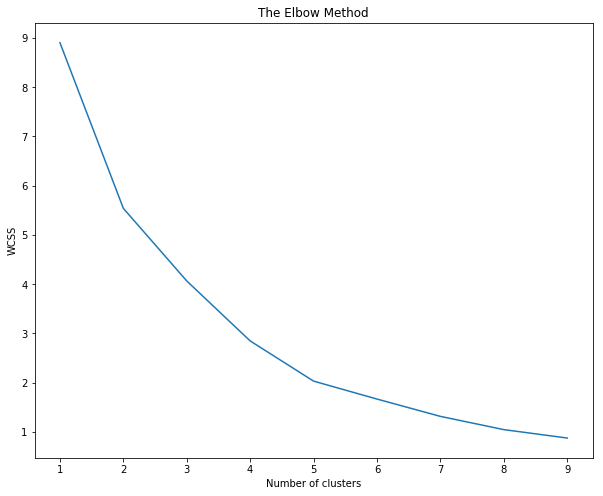

In [21]:
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(salesReportDataTrain_col_fillter_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


__Observation__
1. Suggested numbers of clusters based on selected features.

### Fitting K-Means to the dataset

In [22]:
# Fitting K-Means to the dataset
col_to_drop = ['SalesPersonID','CountOfTransPerSalesPersonID','Suspicious']
salesReportDataTrainTrans_0 = salesReportDataTrainTrans.drop(
    col_to_drop, axis=1).drop_duplicates().reset_index().drop(
            'index',axis=1)

salesReportDataTrain_1 = salesReportDataTrainTrans_0.copy()
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(salesReportDataTrain_col_fillter_df)
#beginning of the cluster numbering with 1 instead of 0
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans)
# Adding cluster to the Dataset1
salesReportDataTrain_1['cluster'] = cluster

salesReportDataTrain_1.shape
salesReportDataTrain_1.head(10)


(992, 4)

,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP,cluster
0,182.900000,2408.000000,12.592662,1
1,157.454545,1292.909091,9.797445,1
2,194.690722,2762.072165,15.862663,1
3,2504.520505,9945.930599,7.656494,1
4,114.553895,1804.472856,14.889162,1
5,1900.462366,51069.591398,25.718997,0
6,1202.680982,30436.932515,27.327132,1
7,6301.366667,15105.166667,3.642248,1
8,2089.655738,11580.081967,12.059214,1
9,6288.000000,28917.222222,6.682821,1


### How good the clusters are?

In [23]:
 silhouette_score(salesReportDataTrain_col_fillter_df, kmeans.labels_, metric='euclidean')

0.7706315895597708

__Observation__
Silhouette score of .77 is moderate quality cluster.

### Calculate properties of formed clusters

In [24]:
salesReportDataTrain_col_fillter_1['cluster'] = cluster
salesReportDataTrain_col_fillter_1.head()
salesReportDataTrain_col_fillter_1.shape
salesReportDataTrain_col_fillter_1.dtypes

,SalesPersonID,CountOfTransPerSalesPersonID,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP,cluster
0,C21116,10,182.900000,2408.000000,12.592662,1
1,C21918,55,157.454545,1292.909091,9.797445,1
2,C22276,97,194.690722,2762.072165,15.862663,1
3,C21820,317,2504.520505,9945.930599,7.656494,1
4,C21976,1271,114.553895,1804.472856,14.889162,1


(992, 6)

SalesPersonID                    object
CountOfTransPerSalesPersonID      int64
MeanQtySoldPerSalesP            float64
MeanTotalSalesValuePerSalesP    float64
MeanTransactionWiseSP           float64
cluster                           int32
dtype: object

In [25]:
salesReportDataTrain_col_fillter_1.groupby('cluster').agg({'MeanQtySoldPerSalesP' : 'mean', 
                                                           'MeanTotalSalesValuePerSalesP' : 'mean',
                                                           'MeanTransactionWiseSP' : 'mean'})

,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP
cluster,,,
0,27370.617437,72126.406225,13.579700
1,1729.287821,9435.193643,15.856214
2,46503.379697,286444.759455,9.591546
3,301250.988380,109890.823130,17.827136
4,201.636364,361639.090909,1037.936180


__Observation__
1. Based on average of all 3 columns attributes grouped by cluster, we can see that cluster 2 & 4 have have noticeable different values from other clusters. These are possible High Risk clusters.
2. Cluster 3 has comparative means, hence a mid risk cluster.
3. cluster 0,1 are low risk.

## Visualize cluster

In [26]:
salesReportDataTrain_col_fillter_df.shape
salesReportDataTrain_col_fillter_df.head()

(992, 3)

,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP
0,0.000240,0.002654,0.011893
1,0.000178,0.000545,0.009199
2,0.000269,0.003324,0.015044
3,0.005932,0.016914,0.007136
4,0.000072,0.001512,0.014106


### Do PCA

Do PCa to visualize the cluster on a 2d space

In [27]:
def do_pca(dataF, n_components=None):
    pca_obj = PCA(n_components)
    pca_obj.fit(dataF)
    return pca_obj

def get_pca_transformation_stats(dataF):
    pca_obj = do_pca(dataF)
    dataF_df = pd.DataFrame(np.cumsum(pca_obj.explained_variance_ratio_)).reset_index()
    dataF_df['index'] = dataF_df['index']+1
    dataF_df = dataF_df.rename({"index": "Number of PC", 0: "Cumulative Sum of variance"}, axis=1)
    return dataF_df
salesReportDataTrain_col_fillter_df_pca = get_pca_transformation_stats(salesReportDataTrain_col_fillter_df)
#salesReportDataTrain_col_fillter_df_pca = salesReportDataTrain_col_fillter_df
salesReportDataTrain_col_fillter_df_pca.head(20)

,Number of PC,Cumulative Sum of variance
0,1,0.640700
1,2,0.886016
2,3,1.000000


__Though the first 2 PC's have a coverage of only 88% variable, lets visualize it on 2D__

In [28]:
def get_pca_trnsformed_data(dataF, n_components=2):
    pca_obj = do_pca(dataF, n_components)
    principalComponents = pca_obj.fit_transform(dataF)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
    return principalDf

salesReportDataTrain_col_fillter_df_pcs_trans = get_pca_trnsformed_data(salesReportDataTrain_col_fillter_df)
#salesReportDataTrain_col_fillter_df_pcs_trans = salesReportDataTrain_col_fillter_df
salesReportDataTrain_col_fillter_df_pcs_trans.head()
salesReportDataTrain_col_fillter_df_pcs_trans.shape

,pc1,pc2
0,-0.030473,-0.005079
1,-0.032552,-0.007108
2,-0.029541,-0.003531
3,-0.016140,-0.004606
4,-0.031247,-0.004616


(992, 2)

### Multi execution for cluster
Run the cluster multiple time with different seeds to verify the cluster stability

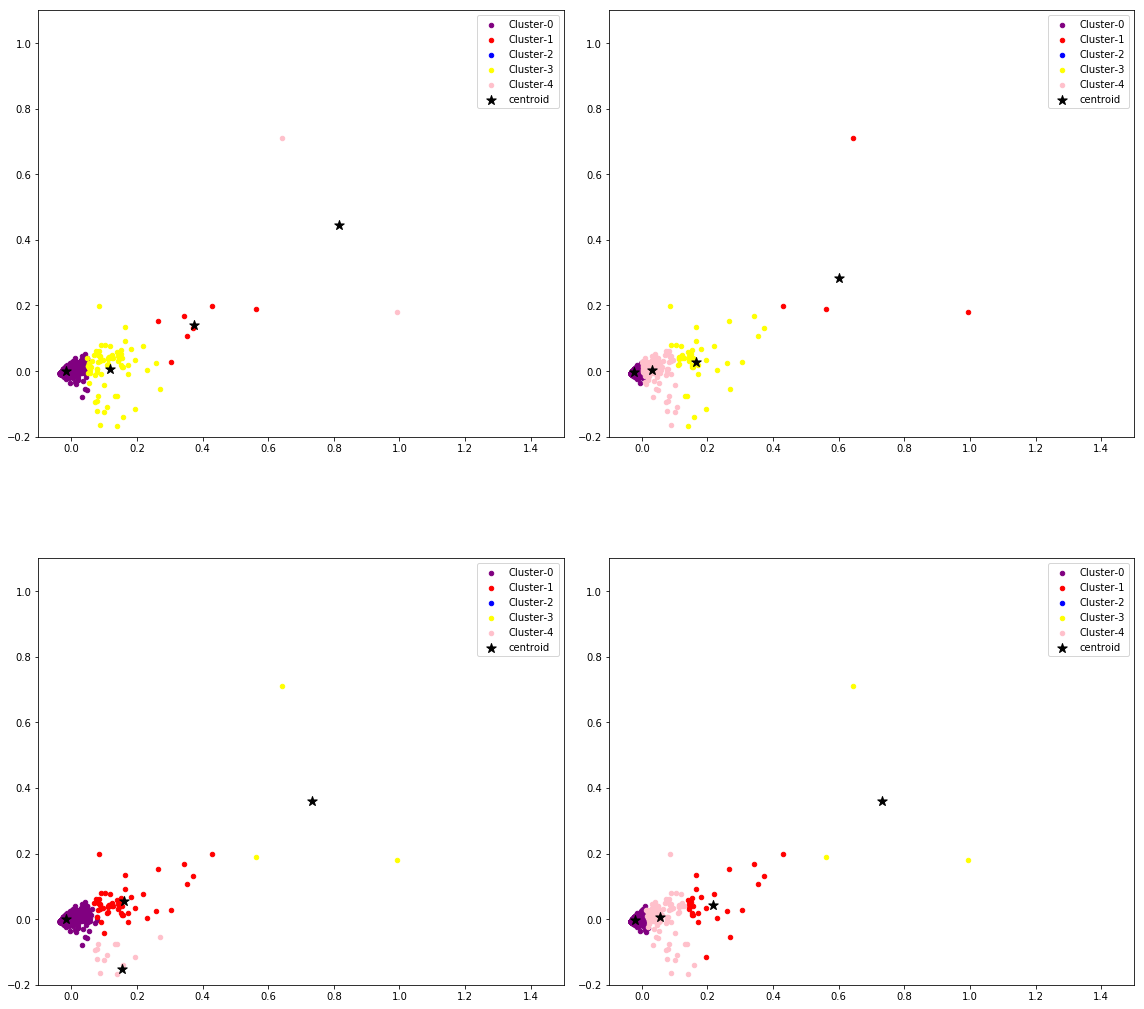

In [29]:
n_iter = 4
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax = np.ravel(ax)
centers = []
for i in range(n_iter):
    km = KMeans(n_clusters=5,
                init = 'k-means++',
                max_iter=3,
                random_state=np.random.randint(0, 1000, size=1)[0])
    y_means = km.fit_predict(salesReportDataTrain_col_fillter_df_pcs_trans)
    centroids = km.cluster_centers_
    centers.append(centroids)
    ax[i].scatter(salesReportDataTrain_col_fillter_df_pcs_trans[y_means==0]['pc1'],
                  salesReportDataTrain_col_fillter_df_pcs_trans[y_means==0]['pc2']
                  ,s=20, c='purple',label='Cluster-0')
    ax[i].scatter(salesReportDataTrain_col_fillter_df_pcs_trans[y_means==1]['pc1'],
                  salesReportDataTrain_col_fillter_df_pcs_trans[y_means==1]['pc2']
                  ,s=20, c='red',label='Cluster-1')
    ax[i].scatter(salesReportDataTrain_col_fillter_df_pcs_trans[y_means==2]['pc1'],
                  salesReportDataTrain_col_fillter_df_pcs_trans[y_means==2]['pc2']
                  ,s=20, c='blue',label='Cluster-2')
    ax[i].scatter(salesReportDataTrain_col_fillter_df_pcs_trans[y_means==3]['pc1'],
                  salesReportDataTrain_col_fillter_df_pcs_trans[y_means==3]['pc2']
                  ,s=20, c='yellow',label='Cluster-3')
    
    ax[i].scatter(salesReportDataTrain_col_fillter_df_pcs_trans[y_means==4]['pc1'],
                  salesReportDataTrain_col_fillter_df_pcs_trans[y_means==4]['pc2']
                  ,s=20, c='pink',label='Cluster-4')
    '''
    ax[i].scatter(salesReportDataTrain_col_fillter_df_pcs_trans[y_means==5]['pc1'],
                  salesReportDataTrain_col_fillter_df_pcs_trans[y_means==5]['pc2']
                  ,s=20, c='green',label='Cluster-5')
    
    ax[i].scatter(salesReportDataTrain_col_fillter_df_pcs_trans[y_means==6]['pc1'],
                  salesReportDataTrain_col_fillter_df_pcs_trans[y_means==6]['pc2']
                  ,s=20, c='brown',label='Cluster-6')
    ax[i].scatter(salesReportDataTrain_col_fillter_df_pcs_trans[y_means==7]['pc1'],
                  salesReportDataTrain_col_fillter_df_pcs_trans[y_means==7]['pc2']
                  ,s=20, c='maroon',label='Cluster-7')
    '''
    ax[i].scatter(centroids[:, 0], centroids[:, 1],
                  c='black', marker='*', s=100, label='centroid')
    ax[i].set_xlim([-0.1, 1.5])
    ax[i].set_ylim([-0.2, 1.1])
    ax[i].legend(loc='best')
    ax[i].set_aspect('equal')
plt.tight_layout();

__Observation__
1. Cluster looks stable.

### Check which Salesman have more frauds - cross check

This is for cross validation on given label data.

__Note : Doesn't impact cluster definition is any way__

Check if clusters are formed based on how may times a Salesman committed fraud in training data.

In [30]:
salesReportDataTrain_1.shape
salesReportDataTrain_1.head()

(992, 4)

,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP,cluster
0,182.900000,2408.000000,12.592662,1
1,157.454545,1292.909091,9.797445,1
2,194.690722,2762.072165,15.862663,1
3,2504.520505,9945.930599,7.656494,1
4,114.553895,1804.472856,14.889162,1


In [31]:
salesReportDataTrain_num_yes = salesReportDataTrain.groupby('SalesPersonID')['Suspicious'].apply(lambda x: (x=='Yes').sum()).reset_index(name='Suspicious_Yes_Count')
salesReportDataTrain_num_yes.head()

,SalesPersonID,Suspicious_Yes_Count
0,C21116,0
1,C21118,1
2,C21119,0
3,C21121,0
4,C21122,0


In [32]:
salesReportDataTrain_2 = salesReportDataTrain_col_fillter_1.merge(salesReportDataTrain_num_yes, on='SalesPersonID')
salesReportDataTrain_2['CountOfTransPerSalesPersonIDYesRatio'] = (salesReportDataTrain_2['Suspicious_Yes_Count']/salesReportDataTrain_2['CountOfTransPerSalesPersonID'])*100
salesReportDataTrain_2.head()
salesReportDataTrain_2.shape

,SalesPersonID,CountOfTransPerSalesPersonID,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP,cluster,Suspicious_Yes_Count,CountOfTransPerSalesPersonIDYesRatio
0,C21116,10,182.900000,2408.000000,12.592662,1,0,0.000000
1,C21918,55,157.454545,1292.909091,9.797445,1,0,0.000000
2,C22276,97,194.690722,2762.072165,15.862663,1,0,0.000000
3,C21820,317,2504.520505,9945.930599,7.656494,1,0,0.000000
4,C21976,1271,114.553895,1804.472856,14.889162,1,1,0.078678


(992, 8)

In [33]:
salesReportDataTrain_3 = salesReportDataTrain_2.merge(salesReportDataTrain_1, on=[
    'MeanQtySoldPerSalesP', 'MeanTotalSalesValuePerSalesP', 'MeanTransactionWiseSP', 'cluster'])
salesReportDataTrain_3.shape
salesReportDataTrain_3.head()

(992, 8)

,SalesPersonID,CountOfTransPerSalesPersonID,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP,cluster,Suspicious_Yes_Count,CountOfTransPerSalesPersonIDYesRatio
0,C21116,10,182.900000,2408.000000,12.592662,1,0,0.000000
1,C21918,55,157.454545,1292.909091,9.797445,1,0,0.000000
2,C22276,97,194.690722,2762.072165,15.862663,1,0,0.000000
3,C21820,317,2504.520505,9945.930599,7.656494,1,0,0.000000
4,C21976,1271,114.553895,1804.472856,14.889162,1,1,0.078678


In [34]:
salesReportDataTrain_3[['SalesPersonID','cluster','Suspicious_Yes_Count']].groupby(
    ['cluster','Suspicious_Yes_Count']).count()

SalesPersonID
cluster Suspicious_Yes_Count               
0       0                                59
        1                                14
        2                                 5
        3                                 1
        4                                 1
1       0                               804
        1                                72
        2                                12
        3                                 7
        4                                 4
        9                                 1
2       0                                 6
        1                                 1
3       0                                 1
        1                                 2
        4                                 1
4       1                                 1

### Visualize cluster in 3d Space

In [35]:
salesReportDataTrain_col_fillter_df['cluster'] =cluster

colorsIdx = {0: 'red', 1: 'blue', 2: 'black', 3:'yellow'}
cols = salesReportDataTrain_col_fillter_df['cluster'].map(colorsIdx)

trace1 = go.Scatter3d(
    x=salesReportDataTrain_col_fillter_df['MeanQtySoldPerSalesP'],
    y=salesReportDataTrain_col_fillter_df['MeanTotalSalesValuePerSalesP'],
    z=salesReportDataTrain_col_fillter_df['MeanTransactionWiseSP'],
    mode='markers',
    marker=dict(
        size=4,
        color=cols,
        colorscale='Viridis',
        opacity=0.8
    )
)

data = [trace1]
fig = go.Figure(data=data)
iplot(fig)

### Validate on Actual test set

In [36]:
salesReportDataTestActual.head()
salesReportDataTestActual.shape
salesReportDataTestActualTrans = featureGenerator.fit_transform(salesReportDataTestActual).drop('ReportID', axis=1).drop_duplicates()
salesReportDataTestActualTrans.head()
salesReportDataTestActualTrans.shape


,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue
0,Rep70101,C21844,PR6483,102,1115
1,Rep70102,C21844,PR6251,102,1050
2,Rep70103,C21844,PR6253,344,3490
3,Rep70104,C21844,PR6378,108,1095
4,Rep70105,C21844,PR6463,146,1055


(9135, 5)

,SalesPersonID,CountOfTransPerSalesPersonID,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP
0,C21844,30,147.300000,1422.000000,10.051409
30,C21840,135,1325.740741,9624.962963,11.830518
165,C22075,12,120.166667,1369.583333,11.483087
177,C21905,34,443.647059,2684.117647,8.019711
211,C22217,83,9293.144578,35051.024096,9.773388


(241, 5)

In [37]:
col_to_drop = ['SalesPersonID', 'CountOfTransPerSalesPersonID']
salesReportDataTestActual_col_fillter = salesReportDataTestActualTrans.drop(col_to_drop, axis=1)
salesReportDataTestActual_col_fillter.head()
salesReportDataTestActual_col_fillter.shape
salesReportDataTestActual_col_fillter.dtypes

,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP
0,147.300000,1422.000000,10.051409
30,1325.740741,9624.962963,11.830518
165,120.166667,1369.583333,11.483087
177,443.647059,2684.117647,8.019711
211,9293.144578,35051.024096,9.773388


(241, 3)

MeanQtySoldPerSalesP            float64
MeanTotalSalesValuePerSalesP    float64
MeanTransactionWiseSP           float64
dtype: object

In [38]:
cat_col = []
num_col = np.setdiff1d(salesReportDataTestActual_col_fillter.columns, cat_col).tolist()

cat_col
num_col

salesReportDataTestActual_col_fillter[num_col] = covert_var(salesReportDataTestActual_col_fillter[num_col], "num_float")    

# Datatype conversions
salesReportDataTestActual_col_fillter.head()
salesReportDataTestActual_col_fillter.dtypes

[]

['MeanQtySoldPerSalesP',
 'MeanTotalSalesValuePerSalesP',
 'MeanTransactionWiseSP']

,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP
0,147.300000,1422.000000,10.051409
30,1325.740741,9624.962963,11.830518
165,120.166667,1369.583333,11.483087
177,443.647059,2684.117647,8.019711
211,9293.144578,35051.024096,9.773388


MeanQtySoldPerSalesP            float64
MeanTotalSalesValuePerSalesP    float64
MeanTransactionWiseSP           float64
dtype: object

In [39]:
salesReportDataTestActual_col_fillter = pipeline.transform(salesReportDataTestActual_col_fillter)
salesReportDataTestActual_col_fillter_df = pd.DataFrame(data=salesReportDataTestActual_col_fillter, 
             columns=pipeline.named_steps['preprocessor'].transformers[0][-1])
salesReportDataTestActual_col_fillter_df.head()
salesReportDataTestActual_col_fillter_df.shape

,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP
0,0.000153,0.000789,0.009444
1,0.003042,0.016307,0.011158
2,0.000086,0.000690,0.010823
3,0.000879,0.003177,0.007486
4,0.022574,0.064407,0.009176


(241, 3)

### Cluster assignment
Check which cluster centroid is closest to these test points & assign


In [40]:
prediction = kmeans.predict(salesReportDataTestActual_col_fillter_df.values)
prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
      dtype=int32)

In [41]:
salesReportDataTestActualTrans['pred'] = prediction
salesReportDataTestActualTrans.head()

,SalesPersonID,CountOfTransPerSalesPersonID,MeanQtySoldPerSalesP,MeanTotalSalesValuePerSalesP,MeanTransactionWiseSP,pred
0,C21844,30,147.300000,1422.000000,10.051409,1
30,C21840,135,1325.740741,9624.962963,11.830518,1
165,C22075,12,120.166667,1369.583333,11.483087,1
177,C21905,34,443.647059,2684.117647,8.019711,1
211,C22217,83,9293.144578,35051.024096,9.773388,1


In [42]:
salesReportDataTestActualTrans['pred'].value_counts()

1    221
0     18
2      2
Name: pred, dtype: int64

In [43]:
salesReportDataTestActual_col_fillter_df['pred']=prediction


colorsIdx = {0: 'red', 1: 'blue', 2: 'black', 3:'yellow'}
cols = salesReportDataTestActual_col_fillter_df['pred'].map(colorsIdx)

trace1 = go.Scatter3d(
    x=salesReportDataTestActual_col_fillter_df['MeanQtySoldPerSalesP'],
    y=salesReportDataTestActual_col_fillter_df['MeanTotalSalesValuePerSalesP'],
    z=salesReportDataTestActual_col_fillter_df['MeanTransactionWiseSP'],
    mode='markers',
    marker=dict(
        size=4,
        color=cols,
        colorscale='Viridis',
        opacity=0.8
    )
)

data = [trace1]
fig = go.Figure(data=data)
iplot(fig)